In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [2]:
train_t = pd.read_csv('train_transaction.csv')
train_i = pd.read_csv('train_identity.csv')
test_t = pd.read_csv('test_transaction.csv')
test_i = pd.read_csv('test_identity.csv')

submission = pd.read_csv('sample_submission.csv')

In [3]:
train = pd.merge(train_t, train_i, on='TransactionID', how='outer')
test = pd.merge(test_t, test_i, on='TransactionID', how='outer')

In [ ]:
print(train.shape)
print(test.shape)
print(submission.shape)

In [ ]:
test.info()

In [ ]:
train

In [ ]:
test

In [ ]:
# train = train.astype('float16', errors='ignore')
# train.info()

In [ ]:
# test = test.astype('int64', errors='ignore')
# test.info()

In [4]:
categorical_features = train.select_dtypes('object').columns
categorical_features

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [5]:
numerical_features = pd.concat([train.select_dtypes('float64'), train.select_dtypes('int64')]).columns
numerical_features

Index(['TransactionAmt', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1',
       'dist2', 'C1', 'C2',
       ...
       'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32', 'TransactionID',
       'isFraud', 'TransactionDT', 'card1'],
      dtype='object', length=403)

In [ ]:
train[categorical_features].iloc[:,15:31]

In [28]:
train.id_31.value_counts()

chrome 63.0                22000
mobile safari 11.0         13423
mobile safari generic      11474
ie 11.0 for desktop         9030
safari generic              8195
                           ...  
iron                           1
LG/K-200                       1
cyberfox                       1
Nokia/Lumia                    1
chrome 67.0 for android        1
Name: id_31, Length: 130, dtype: int64

In [34]:
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows


In [39]:

train.card4.fillna('visa', inplace=True)
train.card6.fillna('debit', inplace=True)
train.P_emaildomain.fillna('gmail.com ', inplace=True)
train.R_emaildomain.fillna('gmail.com ', inplace=True)
train.M1.fillna('T', inplace=True)
train.M2.fillna('T', inplace=True)
train.M3.fillna('T', inplace=True)
train.M4.fillna('M0', inplace=True)
train.M5.fillna('F', inplace=True)
train.M6.fillna('F', inplace=True)
train.M7.fillna('F', inplace=True)
train.M8.fillna('F', inplace=True)
train.M9.fillna('T', inplace=True)
train.id_12.fillna('NotFound', inplace=True)
train.id_15.fillna('Found', inplace=True)
train.id_16.fillna('Found ', inplace=True)
train.id_23.fillna('IP_PROXY:TRANSPARENT', inplace=True)
train.id_27.fillna('Found', inplace=True)
train.id_28.fillna('Found', inplace=True)
train.id_29.fillna('Found', inplace=True)
train.id_30.fillna('Windows', inplace=True)
train.id_31.fillna('chrome 63.0', inplace=True)
train.id_33.fillna('1920x1080', inplace=True)
train.id_34.fillna('match_status:2', inplace=True)
train.id_35.fillna('T', inplace=True)
train.id_36.fillna('F', inplace=True)
train.id_37.fillna('T', inplace=True)
train.id_38.fillna('F', inplace=True)
train.DeviceType.fillna('desktop', inplace=True)
train.DeviceInfo.fillna('Windows', inplace=True)


test.card4.fillna('visa', inplace=True)
test.card6.fillna('debit', inplace=True)
test.P_emaildomain.fillna('gmail.com ', inplace=True)
test.R_emaildomain.fillna('gmail.com ', inplace=True)
test.M1.fillna('T', inplace=True)
test.M2.fillna('T', inplace=True)
test.M3.fillna('T', inplace=True)
test.M4.fillna('M0', inplace=True)
test.M5.fillna('F', inplace=True)
test.M6.fillna('F', inplace=True)
test.M7.fillna('F', inplace=True)
test.M8.fillna('F', inplace=True)
test.M9.fillna('T', inplace=True)
# test.id-12.fillna('NotFound', inplace=True)
# test.id-15.fillna('Found', inplace=True)
# test.id_16.fillna('Found ', inplace=True)
# test.id_23.fillna('IP_PROXY:TRANSPARENT', inplace=True)
# test.id_27.fillna('Found', inplace=True)
# test.id_28.fillna('Found', inplace=True)
# test.id_29.fillna('Found', inplace=True)
# test.id_30.fillna('Windows', inplace=True)
# test.id_31.fillna('chrome 63.0', inplace=True)
# test.id_33.fillna('1920x1080', inplace=True)
# test.id_34.fillna('match_status:2', inplace=True)
# test.id_35.fillna('T', inplace=True)
# test.id_36.fillna('F', inplace=True)
# test.id_37.fillna('T', inplace=True)
# test.id_38.fillna('F', inplace=True)
test.DeviceType.fillna('desktop', inplace=True)
test.DeviceInfo.fillna('Windows', inplace=True)


In [38]:
test[categorical_features].info()

KeyError: "['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'] not in index"

In [ ]:
# missing value 80% 이상 제거
# (train.isnull().sum()/len(train)*100)>80

In [ ]:
train[categorical_features].info()

In [ ]:
# missing value 채우기
train[numerical_features].fillna(-999, inplace=True)
test[numerical_features]fillna(-999, inplace=True)

# 촌나 빨리되네..

In [ ]:
test.select_dtypes('object')

In [42]:
# feature engineering을 위해 tempX, y 생성
## train / test (public LB) validation 느낌   //  private LB (winner)  ((test))
from sklearn.preprocessing import LabelEncoder

total = pd.concat([train, test])   # feature engineering에 train, test 데이터를 모두 담아서 한번에 하기 위해서 total 생성!
split_point = len(train)
# categorical data가 뭔지 모르기 때문에 ordinal encoding 쓰나 one-hot encoding 상관없지만
# one-hot encoding을 하니 컬럼이 너무 많아져서
# total_OHE = pd.get_dummies(data=total, columns=categorical_features)  
# Label Encoding 시도
for i in range(31):
    i += 1
    encoder = LabelEncoder()
    encoder.fit(train[categorical_features[i-1]])
    train[categorical_features[i-1]] = encoder.transform(train[categorical_features[i-1]])
    
# for i in range(31):
#     i += 1
#     encoder = LabelEncoder()
#     encoder.fit(test[categorical_features[i-1]])
#     test[categorical_features[i-1]] = encoder.transform(test[categorical_features[i-1]])

y = train.isFraud
# tempX = total_OHE.drop(columns=["TransactionID", "isFraud"])
tempX = total.drop(columns=["TransactionID", "isFraud"])
# tempX = tempX.drop(columns=card1)
trainX = tempX[:split_point]
testX = tempX[split_point:]
print(trainX.shape, testX.shape, y.shape)



KeyError: 'id_12'

In [43]:
# 1. correlation

# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
def remove_collinearity(X, threshold):
    """
    X : feature matrix
    threshold : 다중공선성을 제거할 column을 고르는 기준 값. [0, 1]
    """
    
    corr = X.corr()
    candidate_cols = []
    
    for x in corr.iterrows():
        idx, row = x[0], x[1] # decoupling tuple
        # 해당 row는 이미 처리가 되어서 볼 필요가 없다.
        if idx in candidate_cols:
            continue
        #print(row[row > 0.7].index[1:])
        candidates = row[row > threshold].index[1:]

        # 자기 자신을 제외하고 threshold를 넘는 column이 있다면,
        if len(candidates) != 0:
            for col in candidates:
                candidate_cols.append(col)           
    
    return candidate_cols

def find_feature_importance(X, model, show_plot):

    feat_names = X.columns.values
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12,12))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
    plt.xlim([-1, len(indices)])
    plt.show()
    
    important_features = X.columns[importances >= 0.005]
    
    return important_features
    
def apply_PCA(X, show_plot):
    from sklearn.decomposition import PCA
    # training data와 test data를 모두 PCA를 이용하여 차원 감소를 수행합니다.
    pca = PCA(n_components=0.90) # 원래 데이터의 90%를 보존하는 차원.
    pca_090 = pca.fit(X) # 학습 및 변환
    reduced_X = pca_090.transform(X)
    print(reduced_X.shape)
    
    if show_plot:
        labels = [f"PC{x}" for x in range(1, reduced_X.shape[1]+1)]
        pca_090_variance = np.round(pca_090.explained_variance_ratio_.cumsum()*100, decimals=1)
        plt.figure(figsize=(25,5))
        plt.bar(x=range(1, len(pca_090_variance)+1), height=pca_090_variance, tick_label=labels)

        plt.xticks(rotation=90, color='indigo', size=15)
        plt.yticks(rotation=0, color='indigo', size=15)
        plt.title('Scree Plot',color='tab:orange', fontsize=25)
        plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
        plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
        plt.show()
        
        X_train_pca_df = pd.DataFrame(reduced_X, columns=labels)
        display(X_train_pca_df)

    return pca_090, X_train_pca_df

In [50]:
# flag setting
feature_reducing = "feature_importance" # "correlation" / "feature_importance" / "PCA"

In [45]:
for i in range(10):
    i += 1
    print(trainX.isnull().sum()[(i-1)*50 : i*50])
    print(' ')

TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4                  0
card5               4259
card6                  0
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain          0
R_emaildomain          0
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287


In [46]:
trainX.fillna(-999, inplace=True)

/var/folders/p9/rqr7k68d4zsb31fs5zkgqnwh0000gn/T/ipykernel_3619/3890869156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainX.fillna(-999, inplace=True)


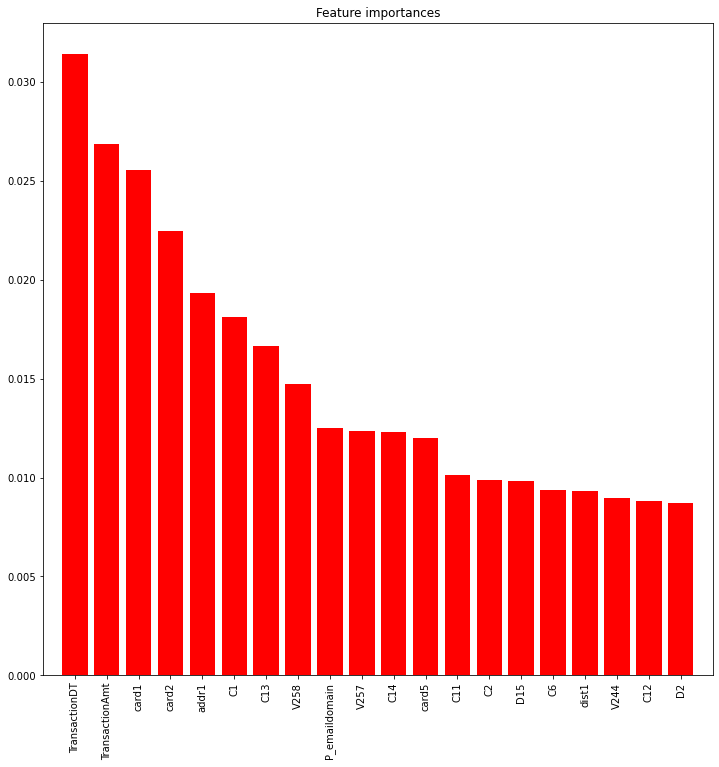

(590540, 48)


In [51]:
# PCA 적용
if feature_reducing == "correlation":
    threshold = 0.7
    correlated_features = remove_collinearity(trainX, threshold)
    correlated_features = set(correlated_features) # 중복 제거
    print("%d Correlation features over %.2f" % (len(correlated_features), threshold))
    
    X = trainX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    show_plot = True
    model = RandomForestRegressor(max_features="sqrt", n_jobs=-1, random_state=0xC0FFEE)
    model.fit(trainX, y)
    important_features = find_feature_importance(trainX, model, show_plot)
    X = trainX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    show_plot = True
    pca_model, X = apply_PCA(trainX, show_plot)
    print(X.shape)

In [52]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(531486, 48) (59054, 48) (531486,) (59054,)


In [53]:
print("\nFitting Random Forest...")
model = RandomForestRegressor(max_features='sqrt', n_jobs=-1)
model.fit(X_train, y_train)


Fitting Random Forest...


RandomForestRegressor(max_features='sqrt', n_jobs=-1)

In [54]:
from sklearn.metrics import r2_score
evaluation_metric = r2_score

In [55]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.9372
Test Score : 0.5461


In [58]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2'])
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=0xC0FFEE)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [60]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="RF", direction="maximize") # regression task에서 R^2를 최대화!
rf_study.optimize(opt_func, n_trials=5)

[I 2022-06-30 20:47:48,420] A new study created in memory with name: RF
[I 2022-06-30 20:50:12,664] Trial 0 finished with value: 0.5141127198685691 and parameters: {'n_estimators': 142, 'max_depth': 25, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5141127198685691.
[I 2022-06-30 20:51:18,554] Trial 1 finished with value: 0.36896970719551686 and parameters: {'n_estimators': 121, 'max_depth': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5141127198685691.
[I 2022-06-30 20:52:47,887] Trial 2 finished with value: 0.35135081847709204 and parameters: {'n_estimators': 182, 'max_depth': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5141127198685691.
[I 2022-06-30 20:53:59,666] Trial 3 finished with value: 0.3693005304952619 and parameters: {'n_estimators': 138, 'max_depth': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5141127198685691.
[I 2022-06-30 20:56:05,458] Trial 4 finished with value: 0.4793689779024944 and parameters: {'n_estimators': 1

In [61]:
# optuna가 시도했던 모든 실험 관련 데이터
rf_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_n_estimators,state
0,0,0.514113,2022-06-30 20:47:48.422159,2022-06-30 20:50:12.664167,0 days 00:02:24.242008,25,sqrt,142,COMPLETE
1,1,0.368970,2022-06-30 20:50:12.664742,2022-06-30 20:51:18.554579,0 days 00:01:05.889837,12,sqrt,121,COMPLETE
2,2,0.351351,2022-06-30 20:51:18.555123,2022-06-30 20:52:47.887199,0 days 00:01:29.332076,11,sqrt,182,COMPLETE
3,3,0.369301,2022-06-30 20:52:47.887745,2022-06-30 20:53:59.666693,0 days 00:01:11.778948,12,sqrt,138,COMPLETE
4,4,0.479369,2022-06-30 20:53:59.667199,2022-06-30 20:56:05.458637,0 days 00:02:05.791438,20,sqrt,158,COMPLETE


In [62]:
print("Best Score: %.4f" % rf_study.best_value) # best score 출력
print("Best params: ", rf_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.5141
Best params:  {'n_estimators': 142, 'max_depth': 25, 'max_features': 'sqrt'}


In [63]:
final_rf_model = RandomForestRegressor(n_estimators=rf_study.best_trial.params["n_estimators"],
                                 max_depth=rf_study.best_trial.params["max_depth"],
                                 max_features=rf_study.best_trial.params["max_features"])

final_rf_model.fit(X, y) # finalize model

RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=142)

In [64]:
# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)

(590540, 48)


In [85]:
prediction = final_rf_model.predict(test)
prediction

array([0.04424275, 0.04575464, 0.06658472, ..., 0.01577107, 0.06362012,
       0.05813689])

In [71]:
test.select_dtypes('object')

,card4,card6,P_emaildomain,DeviceInfo
0,visa,debit,gmail.com,Windows
1,visa,debit,aol.com,Windows
2,visa,debit,hotmail.com,Windows
3,visa,debit,gmail.com,Windows
4,mastercard,debit,gmail.com,Windows
...,...,...,...,...
506686,mastercard,debit,gmail.com,Windows
506687,mastercard,debit,hotmail.com,ALE-L23 Build/HuaweiALE-L23
506688,visa,debit,hotmail.com,Windows
506689,mastercard,debit,hotmail.com,Windows


In [84]:
test.select_dtypes('float64').fillna(-999, inplace=True)

In [76]:
encoder = LabelEncoder()
encoder.fit(test['DeviceInfo'])
test['DeviceInfo'] = encoder.transform(test['DeviceInfo'])

/var/folders/p9/rqr7k68d4zsb31fs5zkgqnwh0000gn/T/ipykernel_3619/1469926047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['DeviceInfo'] = encoder.transform(test['DeviceInfo'])


In [96]:
submission["isFraud"] = prediction
submission

,TransactionID,isFraud
0,3663549,0.044243
1,3663550,0.045755
2,3663551,0.066585
3,3663552,0.113267
4,3663553,0.079256
...,...,...
506686,4170235,0.039269
506687,4170236,0.148591
506688,4170237,0.015771
506689,4170238,0.063620


In [98]:
submission.reset_index(drop=True).to_csv(f"rf_submission_{feature_reducing}.csv", index=False)